In [152]:
import tensorflow as tf
# tensorflow_io provides extended data formats and
# the ability to stream data
import tensorflow_io as tfio
import os
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Audio

In [153]:
contents = os.getcwd() + '/tronica_trimmed.wav'
sample_rate = 48000
# in number of seconds
slice_length = 10
# number of samples we will use for our slices
s_len = sample_rate*slice_length
print("samples in slice: ", s_len)

samples in slice:  480000


The Below code will take the sample and split it into two stereo samples

In [148]:
# Import AudioSegment from pydub
from pydub import AudioSegment
  
# Open the stereo audio file as
# an AudioSegment instance
stereo_audio = AudioSegment.from_file(
    contents,
    format="wav")

# read the audio file into an IOTensor
audio = tfio.audio.AudioIOTensor(contents)
# slice the audio tensor into a bunch of tensors that are each 10 seconds long

audio_slice = audio
print(audio_slice)
Audio(audio[:1].numpy(), rate=audio.rate.numpy())

In [151]:
# Calling the split_to_mono method
# on the stereo audio file
mono_audios = stereo_audio.split_to_mono()
  
# Exporting/Saving the two mono
# audio files present at index 0(left)
# and index 1(right) of list returned
# by split_to_mono method
left_path = contents[:-4]+"_left.wav"
right_path = contents[:-4]+"_right.wav"
print(left_path)
print(right_path)

mono_left = mono_audios[0].export(
    left_path,
    format="wav")
mono_right = mono_audios[1].export(
    right_path,
    format="wav")

/Users/nathan/workspace/tensor_flow_projects/audio_experiments/tronica_trimmed_left.wav
/Users/nathan/workspace/tensor_flow_projects/audio_experiments/tronica_trimmed_right.wav


In [156]:
print(audio_slice)
slice_tensor = tf.cast(audio_slice, tf.float32) / 32768.0
print(slice_tensor)
# add a fade out at the start and end
faded_tensor = tfio.audio.fade(slice_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")
plt.figure()
plt.plot(faded_tensor.numpy())

<AudioIOTensor: shape=[2425819       2], dtype=<dtype: 'int16'>, rate=48000>


ValueError: TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 1102, in __len__

TypeError: Scalar tensor has no `len()`



Now we are going to create a spectrogram of our audio file...

In [157]:
fft_size = 512
window_size = 512
stride = 256

spectrogram = tfio.audio.spectrogram(
    faded_tensor, nfft=fft_size, window=window_size, stride=stride)
print(spectrogram.shape)
# remove an extra single dimension axis,
# I am not sure where it comes from...
squeezed_spectrogram = tf.squeeze(tf.math.log(spectrogram).numpy(), axis=[-2])
print(squeezed_spectrogram.shape)

(480000, 1, 257)
(480000, 257)


In [110]:
print(spectrogram)

tf.Tensor(
[[      -inf       -inf       -inf ...       -inf       -inf       -inf]
 [-24.486326 -24.486326 -24.486326 ... -24.486322 -24.486322 -24.486326]
 [-21.741388 -21.741388 -21.741388 ... -21.741385 -21.741385 -21.741388]
 ...
 [-18.680403 -18.680403 -18.680403 ... -18.680399 -18.680399 -18.680403]
 [-19.418322 -19.418322 -19.418322 ... -19.418318 -19.41832  -19.418322]
 [      -inf       -inf       -inf ...       -inf       -inf       -inf]], shape=(480000, 257), dtype=float32)


Now lets plot our spectrogram

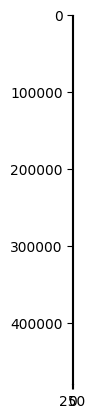

In [131]:
# derr there is something wrong with how this displays....
plt.figure()
plt.imshow(squeezed_spectrogram)
# plt.specgram(spectrogram[0], NFFT=fft_size, window=window_size)

In [132]:
Audio(faded_tensor[:1].numpy(), rate=audio.rate.numpy())

NameError: name 'slice_tensor' is not defined

In [133]:
#Playback the audio file

# save the tensor as a string that can be saved as a .wav file
# unable to encode as the tensor is an int tensor and not a float tensor
tf.audio.encode_wav(
    audio_slice, sample_rate, name="test.wav"
)

ValueError: TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 1102, in __len__

TypeError: Scalar tensor has no `len()`



In [134]:
t = np.arange(0, audio.len(), 1)
fig, (ax1, ax2) = plt.subplots(nrows=2)
plt.plot(audio)
plt.spectrogram(audio)
plt.show()

AttributeError: 'AudioIOTensor' object has no attribute 'len'

In [135]:
plt.spectrogram(audio);

AttributeError: module 'matplotlib.pyplot' has no attribute 'spectrogram'

In [136]:
tf.autograph.to_graph(contents)

ConversionError: converting /Users/nathan/workspace/tensor_flow_projects/audio_experiments/tronica_trimmed.wav: ValueError: Cannot apply autograph to a function that doesn't expose a __code__ object. If this is a @tf.function, try passing f.python_function instead.

In [137]:
audio2 = tf.audio.decode_wav(
    contents, desired_channels=2
)
print(audio2)

2023-02-17 14:54:39.323892: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at decode_wav_op.cc:55 : INVALID_ARGUMENT: Header mismatch: Expected RIFF but found /Use


InvalidArgumentError: {{function_node __wrapped__DecodeWav_device_/job:localhost/replica:0/task:0/device:CPU:0}} Header mismatch: Expected RIFF but found /Use [Op:DecodeWav]